# Lane Line Detection on Roads
Recognizing lane lines on roads is very important for a human driver to determine the road segment she should drive on. While this comes as natural for human perception, teaching a computer to recognize lane lines is a challenging task. 

Advanced Driver Assistance Systems (ADAS) in modern cars provides lane-keeping features that detects lane lines on a road. Autonomous vehicles (AV) uses sophisticated lane line detection techniques to keep the car on the drivable segment on a road.

This project uses a computer vision pipeline to deect lane lines on images and videos. 


# Image/Video Processing Pipeline
The following image processing is used in this project to detct lane lines:
- Gaussian blurring
- RGB to HSV transformation
- Canny Edge detection
- Selection of a region of interest (ROI)
- Hough transform and lane line detection

## Import Packages

In [1]:
#importing some useful packages
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


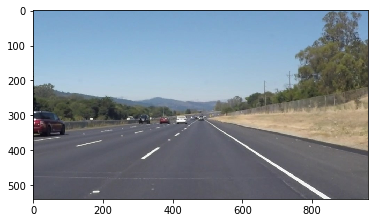

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
def gaussianBlur(img, kernel_size):
    """ 
    Blurs the img using a Gaussian filter. 
    It uses kernel convolution method to reduce noise. 
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [4]:
def hsvTransform(blurred_img):
    """
    Transformss the Gaussian blurred image into HSV space.
    """
    return cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)

In [5]:
def selectYellowAndWhiteLines(hsv_img):
    """
    Selects the Yellow and White components in the HSV space. It's a two step process:
    1. set the Yellow and White lower & upper thresholds
    2. creates Yellow and White masks and superimpose them
    
    The Yellow and White thresholds are set by trial and error. Different values
    can be experimented with.
    """
    # Yellow mask formation
    yellow_lower = np.array([60, 100, 100])
    yellow_upper = np.array([100, 255, 255])
    yellow_mask = cv2.inRange(hsv_img, yellow_lower, yellow_upper)
    
    # White mask formation
    while_lower = np.array([0, 0, 180])
    while_upper = np.array([175, 30, 255])
    white_mask = cv2.inRange(hsv_img, while_lower, while_upper)
    
    # disjoint Yellow and White masks to get a mask with only Yellow and White components
    yellow_white_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    # select only the Yellow and White portion of hsv_img
    img = cv2.bitwise_and(hsv_img, hsv_img, mask = yellow_white_mask)
    
    return img

In [6]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [10]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build the Lane Finding Pipeline

In [11]:
def lane_detection_pipeline(img):
    """
    1. set parameters
    2. apply Gaussian blur
    3. convert image from BGR to HSV
    4. Yello and White line filtering
    5. detect Canny edge
    6. obtain region of interest
    7. apply Hough trasnform on Canny edge detected image
    8. augment the lane lines
    
    """
    ### 1. Set the parameters for different helper functions ###
    # gaussianBlur
    kernel_size = 5

    # canny edge detection
    low_threshold = 50
    high_threshold = 150

    # region_of_interest
    img_height, img_width, _ = image.shape
    width_scale = 1/2
    height_scale = 2/3

    bottom_left = [0, img_height - 1] # note height of the image starts at upper-left corner
    bottom_right = [img_width - 1, img_height - 1 ]
    upper_left = [width_scale * img_width, height_scale * img_height]
    upper_right = [(1-width_scale) * img_width, height_scale * img_height]

    # hough_lines
    rho = 2 # distance resolution (in pixels) in Hough space
    theta = np.pi / 180 # angular resolution (in radians) in Hough space
    threshold = 10 # minimum number of required votes (i.e., number of intersecting lines) of a point in Hough space
    min_line_length = 10 # minimum of number of pixels to make up a line
    max_line_gap = 30 # maximum gap in pixels between two connectable line segments
    
    # 2. apply Gaussian blur
    img_blur = gaussianBlur(image, kernel_size)
    
    # 3. HSV transformation
    img_hsv = hsvTransform(img_blur)
    
    # 4. filter the Yellow and White lines
    img_hsv_filtered = selectYellowAndWhiteLines(img_hsv)
    
    # 5. apply Canny edge detection
    img_canny = canny(img_hsv_filtered, low_threshold, high_threshold)
    
    # 6. obtain region of interest (roi)
    #vertices = np.array([[bottom_left, bottom_right, upper_right, upper_left]])
    #vertices = np.array([[bottom_left, upper_left,upper_right, bottom_right]])
    vertices = np.array([[(450, 300), (500, 300), (img_width, img_height), (0, img_height)]])
    roi = region_of_interest(img_canny, vertices)
    
    # 7. Hough transform: output 'lines' is an array that contains end points of 
    # detected line segments
    img_lines = hough_lines(roi, rho, theta, threshold, min_line_length, max_line_gap)
    
    # 8. draw lines on the edge image
    output_image = weighted_img(img_lines, image)
    
    return output_image
    

# Testing on images
Let's try the lane line detection pipeline on images.    

In [12]:
image_aug1 = lane_detection_pipeline("test_images/solidYellowLeft.jpg")

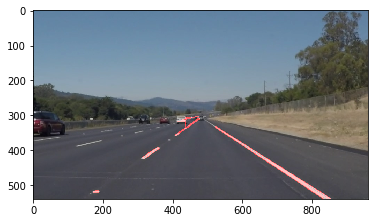

In [13]:
plt.imshow(image_aug1)